## Autoencoder
Structure:
- Encoder
- Latent Space
- Distance function("loss")

Characteristic:
- Data-specific
- Lossy
- Automatic learning

#### Usage of autoencoder:
- Image segmentation
- Reconstruction/denoise
- Dimensionality Reduction for visualization

Network Training Process:\
Stage1: Data preparation: Data loading -> Dara pre-processing\
Stage2: Building the model -> Compile the model -> Train the model\
Stage3: Model Evaluation -> Model Prediction\
Stage4: Performance Evaluation\

Data preparation: Data Loading
- build in data library (easy, no customize)
    - only has common datasets
    - e.g. tf.keras.dataset.mnist.load_data()
- tf.keras.preprocessing.image_dataset_from_directory() (medium, limited customize)
    - only works for tf_version = 2.3.0
    - limited image formats: jpeg, png, bmp, gif
- tf.data.Dataset: (hard, fully customize)
    - Dataset = tf.data.Dataset.list_files("filename_pattern")
    - Dataset.map(lambda_function_for_image_reading)
    
#### Data preparation: Data pre-processing
Why do we need pre-processing?
- messy and from different sources
- standardize and clean up
- reduce complexity and increase performance

Techniques:
- reduce complexity 
    - convert to grey scale
- standardize images
    - clip
    - crop
    - normalization
- change data structure for specific task
    - one-hot encoding
    
### Training stage: Build the model
Common Layers:
- input layers
    - SHAPE is important (None, h, w, channel_number)
    - Let's say we have a input set with shape of (Number of images, h ,w)
    - The input needs to be 4D tensor when using 2D operation (CONV2D) or 5D tensor when using 3D operation (CONV3D)
    - tf.keras.Input(shape = (h,w,channel_number))
- Hidden layers:
    - Connecting Layer
        - Dense Layer
            - tf.keras.layers.Dense(units, activation, kernel_initialize, activity_regularizer, ...)
        - Convolutional Layer
            - tf.keras.layers.Conv2D(filters, kernel_size, strides, padding, activation, kernel_initialize, activity_regularizer, ...)
    - Sampling layers:
        - Pooling layers (down-sampling)
            - tf.keras.layers.MaxPool2D(pool_size, strides, padding)
        - Up-sampling layer
            - tf.keras.layers.UpSampling2D(size, interpolation)

- Activation:
    - Hidden layer activation
    ReLU and Leaky ReLU
    - Output layer activation
    Sigmoid and SoftMax
    
### Training stage: Compile the model
Optimizer:
- Gradient Descent:
    - Depends on first order derivative of a loss function
    - Calculates which way the weights should alter to reach minima
- Stochastic Gradient Descent("SGD")
    - A variant of Gradient Descent, which update parameters more frequently
- Momentum:
    - Gradient Descent with momentum term
    - Reducing high variance in SGD and softens the convergence
- Root Mean Square Propagation("rmsprop")
    - Gradient descent with momentum
    - Weights updating in vertical direction is restricted, so we could increase learning rate and the algorithm could take larger step
- Adaptive Momentum Estimation("Adam")
    - works with momentums of first and second order
    
loss:
- Mean square error("mse")
    - Evaluate the similarity between input and output
- CrossEntropy
- Binary CrossEntropy("binary_crossentropy")
    - Binary classes
    - Sigmoid + crossentropy
- Categorical CrossEntropy("categorical_crossentropy")
    - Multiple classes
    - SoftMax + crossentropy
    - Special case for one-hot encoding
    - ti = 1 only for positive class, other classes will be zero
    
### Training stage: Train the model
Model Training:
- Model.fit() (easy, not customizable)
    - Batch_size
    - Epochs
    - Validation_split
    - Callbacks
        - Actions which can be performed at various stages of training
        - ModelCheckpoint
        - Tensorboard
- tf.GradientTape() (hard, fully customizable)

### Evaluation stage: Performance Evaluation
Common Evaluation process:
- check the output results visually
    - plt.imshow()
- check the trainng plot
    - use tensorboard
    - tensorboard --logdir="tensorboard_path"
- Perform evaluation using metric
    - calculate the "accuracy" between predicted label image and ground truth label image
    - Metrics: 
        - DSC
        - Surface distance
        - MSE

## Unet
Encoder-Decoder Structure
- Contracting path
    - Convolution layer
    - Max-pooling layer
- Expanding path
    - Convolution layer
    - Up-sampling or Deconcolvtion layer
- Skip connection (long connection)
    - Concatenation layer

In [3]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from matplotlib import pyplot as plt

In [5]:
# load image and preprocessing
(x_train, _) , (x_test, _) = mnist.load_data()

print(x_train.shape)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

(60000, 28, 28)


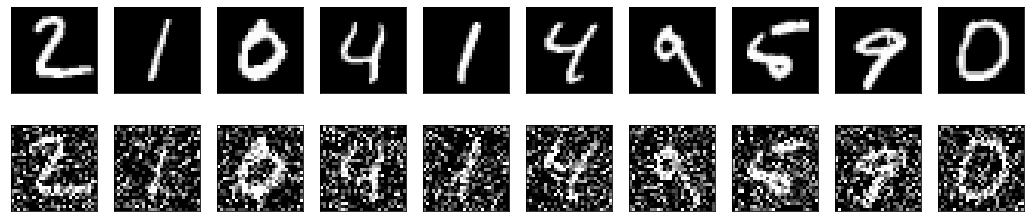

In [6]:
# plot the input image
n =11
plt.figure(figsize=(20,4))
for i in range(1,n):
    # display origin
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display noise version
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
# Build the model
input_img = Input(shape=(28,28,1)) # adpot this if using 'channels_first' image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# since the image is only two classes(black or white), so use sigmoid
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 32)       

In [10]:
# Compile the model
autoencoder.compile(optimizer='Adam', loss = 'binary_crossentropy')

In [12]:
# Train the model
autoencoder.fit(x_train_noisy, x_train, 
               epochs=50,
               batch_size=128,
               shuffle=True,
               validation_data=(x_test_noisy, x_test),
               callbacks=[TensorBoard(log_dir='./tb', histogram_freq=0, write_graph=False)])

Epoch 1/50
  1/469 [..............................] - ETA: 0s - loss: 0.6912WARNING:tensorflow:From C:\Users\Daniel Zhang\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
469/469 [==============================] - 98s 209ms/step - loss: 0.1671 - val_loss: 0.1172
Epoch 2/50
469/469 [==============================] - 92s 197ms/step - loss: 0.1139 - val_loss: 0.1095
Epoch 3/50
469/469 [==============================] - 88s 188ms/step - loss: 0.1083 - val_loss: 0.1060
Epoch 4/50
469/469 [==============================] - 82s 175ms/step - loss: 0.1051 - val_loss: 0.1031
Epoch 5/50
469/469 [==============================] - 89s 190ms/step - loss: 0.1030 - val_loss: 0.1013
Epoch 6/50
469/469 [==============================] - 97s 208ms/step - loss: 0.1016 - val_loss: 0.1001
Epoch 7/50

In [ ]:
# Predict the output
decoded_imgs = autoencoder.predict(x_test_noisy)

In [ ]:
# plot the output for evalution

n = 10
plt.figure(figsize=(20,4))
for i in range(1,n):
    # display origin
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display noise version
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()